In [1]:
import pandas as pd
import numpy as np
import pyodbc 
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.metrics import mean_squared_error

In [26]:
#Server probably offline. Use attached files and import files directly underneath.
#Change the patient number to test different patients. 
server   = '***********'
database = 'EKG_patients' 
username = 'Read_only_public' 
password = '***********' 

cnxn = pyodbc.connect('Driver={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

cursor.execute('SELECT * FROM ECG_4_AVR')
data_AVR = np.array(cursor.fetchall())
data_AVR = data_AVR.astype('float64')
#data_AVR = data_AVR - data_AVR.mean()    #already normalized

cursor.execute('SELECT * FROM ECG_4_II')
data_II = np.array(cursor.fetchall())
data_II = data_II.astype('float64')

cursor.execute('SELECT * FROM ECG_4_V')
data_V = np.array(cursor.fetchall())
data_V = data_V.astype('float64')
#data_V = data_V - data_V.mean()    #already normalized

cursor.execute('SELECT * FROM ECG_4_II_missing')
data_II_missing = np.array(cursor.fetchall())
data_II_missing = data_II_missing.astype('float64')

In [2]:
# Direct data import, pick patient by changing the number.

data_AVR = pd.read_csv("ECG_4_AVR.csv")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    data_AVR.to_csv("file_name.csv", sep='\t', encoding='utf-8')
    
data_II = pd.read_csv("ECG_4_II.csv")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    data_II.to_csv("file_name.csv", sep='\t', encoding='utf-8')    
    
data_II_missing = pd.read_csv("ECG_4_II_missing.csv")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    data_II_missing.to_csv("file_name.csv", sep='\t', encoding='utf-8')
    
data_V = pd.read_csv("ECG_4_V.csv")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    data_V.to_csv("file_name.csv", sep='\t', encoding='utf-8')
    
data_II_complete = np.concatenate([data_II, data_II_missing])  

In [3]:
# Removing testdata from all data.
train_feature_I = data_AVR[0:data_AVR.size-3750]
train_feature_II = data_V[0:data_AVR.size-3750]
train_label = data_II  

class_names = ['feature_I', 'feature_II', 'label']

In [4]:
# Formating data.

# train label
my_train_label = np.c_[train_label]
my_train_label = my_train_label.astype('float64')
class_names = ['label']
df_train_label = pd.DataFrame(data=my_train_label, columns=class_names)

# train features
my_train_features = np.c_[train_feature_I,train_feature_II]
my_train_features = my_train_features.astype('float64')
class_names = ['feature_I', 'feature_II']
df_train_features = pd.DataFrame(data=my_train_features, columns=class_names)

In [5]:
def build_model():
  model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=(2,)),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

In [6]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                36        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [7]:
EPOCHS = 150

history = model.fit(
  my_train_features, my_train_label,
  epochs=EPOCHS, validation_split = 0.00001, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0017,  mae:0.0244,  mse:0.0017,  val_loss:0.0006,  val_mae:0.0253,  val_mse:0.0006,  
....................................................................................................
Epoch: 100, loss:0.0002,  mae:0.0091,  mse:0.0002,  val_loss:0.0001,  val_mae:0.0085,  val_mse:0.0001,  
..................................................

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
145,0.000200,0.009027,0.000200,0.000094,0.009713,0.000094,145
146,0.000198,0.008987,0.000198,0.000029,0.005389,0.000029,146
147,0.000199,0.008949,0.000199,0.000067,0.008201,0.000067,147
148,0.000202,0.009037,0.000202,0.000037,0.006080,0.000037,148
149,0.000195,0.008927,0.000195,0.000016,0.003960,0.000016,149


In [9]:
# Removing training data from all data.

test_feature_I = data_AVR[data_AVR.size-3749:data_AVR.size]   #test_feature_I.size    3749
test_feature_II = data_V[data_AVR.size-3749:data_AVR.size]    #test_feature_II.size   3749
test_label = data_II_missing                                  #test_label.size        3749

# test features
my_test_features = np.c_[test_feature_I,test_feature_II]    #3749
my_test_features = my_test_features.astype('float64')
class_names = ['feature_I', 'feature_II']
df_test_features = pd.DataFrame(data=my_test_features, columns=class_names)

# test label
my_test_label = np.c_[test_label]     #3749
my_test_label = my_test_label.astype('float64')
class_names = ['label']
df_test_label = pd.DataFrame(data=my_test_label, columns=class_names)

In [10]:
# Final model prediction with test data as input.
test_predictions = model.predict(my_test_features).flatten()

Text(0.5, 1.0, 'Predicted data')

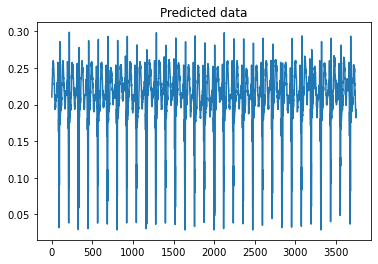

In [11]:
plt.plot(test_predictions)
plt.title('Predicted data')

Text(0.5, 1.0, 'Training and predicted data (disregard the prediction start.)')

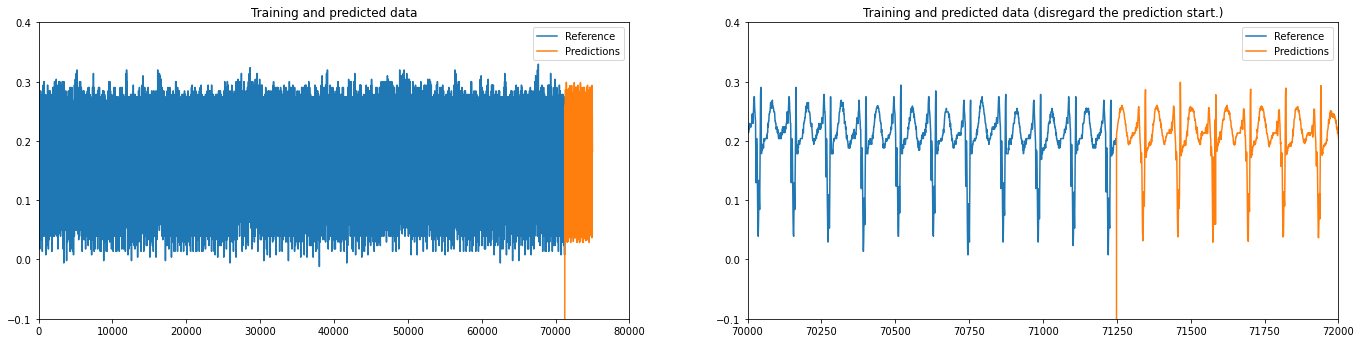

In [19]:
plt.figure(figsize=(36,12)) #(35,12)

plt.subplot(231)
#line_down = plt.plot(      np.append(data_II, test_predictions)             ,label='Predictions')
line_up, = plt.plot(data_II, label='Reference')
line_down, = plt.plot( np.append((-5)*np.ones(data_II.size), test_predictions ),   label='Predictions')
plt.xlim([0, 80000])
plt.ylim([-0.1, 0.4])
plt.legend(handles=[line_up, line_down])
plt.title('Training and predicted data')

plt.subplot(232)
#line_down = plt.plot(      np.append(data_II, test_predictions)             ,label='Predictions')
line_up, = plt.plot(data_II, label='Reference')
line_down, = plt.plot( np.append((-5)*np.ones(data_II.size), test_predictions ),   label='Predictions')
plt.xlim([70000, 72000])
plt.ylim([-0.1, 0.4])
plt.legend(handles=[line_up, line_down])
plt.title('Training and predicted data (disregard the prediction start.)')

Text(0.5, 1.0, 'Test data and predicted data (full length)')

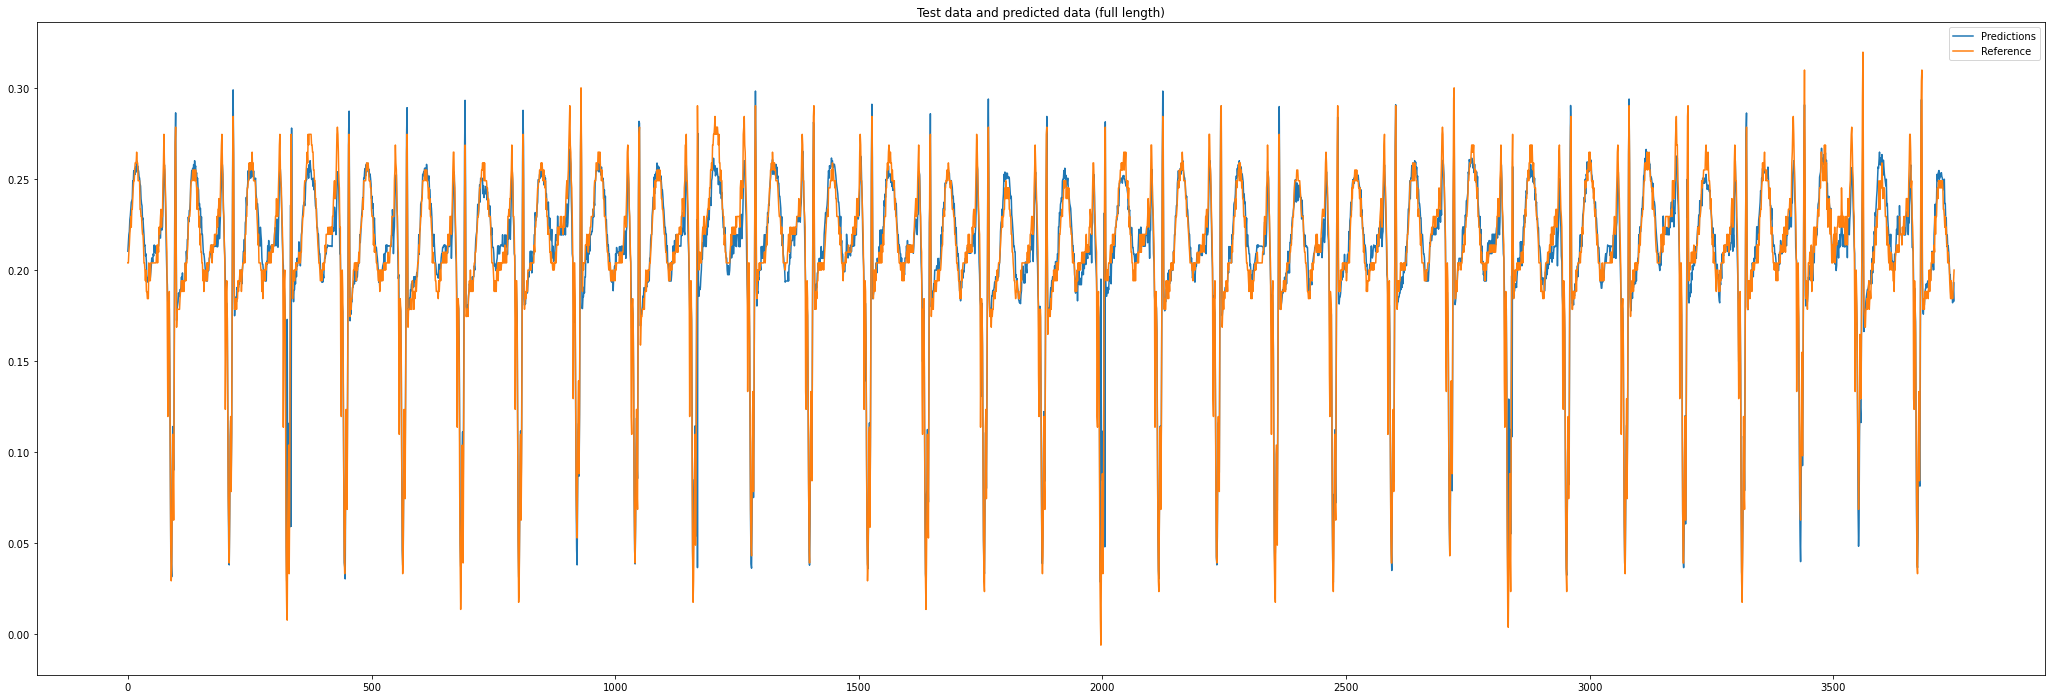

In [13]:
plt.figure(figsize=(36,12)) #(35,12)
#plt.ylim([-0.1, 0.4])
#plt.xlim([3500, 3750])
line_up, = plt.plot(test_predictions, label='Predictions')
line_down, = plt.plot(my_test_label, label='Reference')
plt.savefig('foo.png', bbox_inches='tight')
plt.legend(handles=[line_up, line_down])
plt.title('Test data and predicted data (full length)')

Text(0.5, 1.0, 'Test data and predicted data (close-up)')

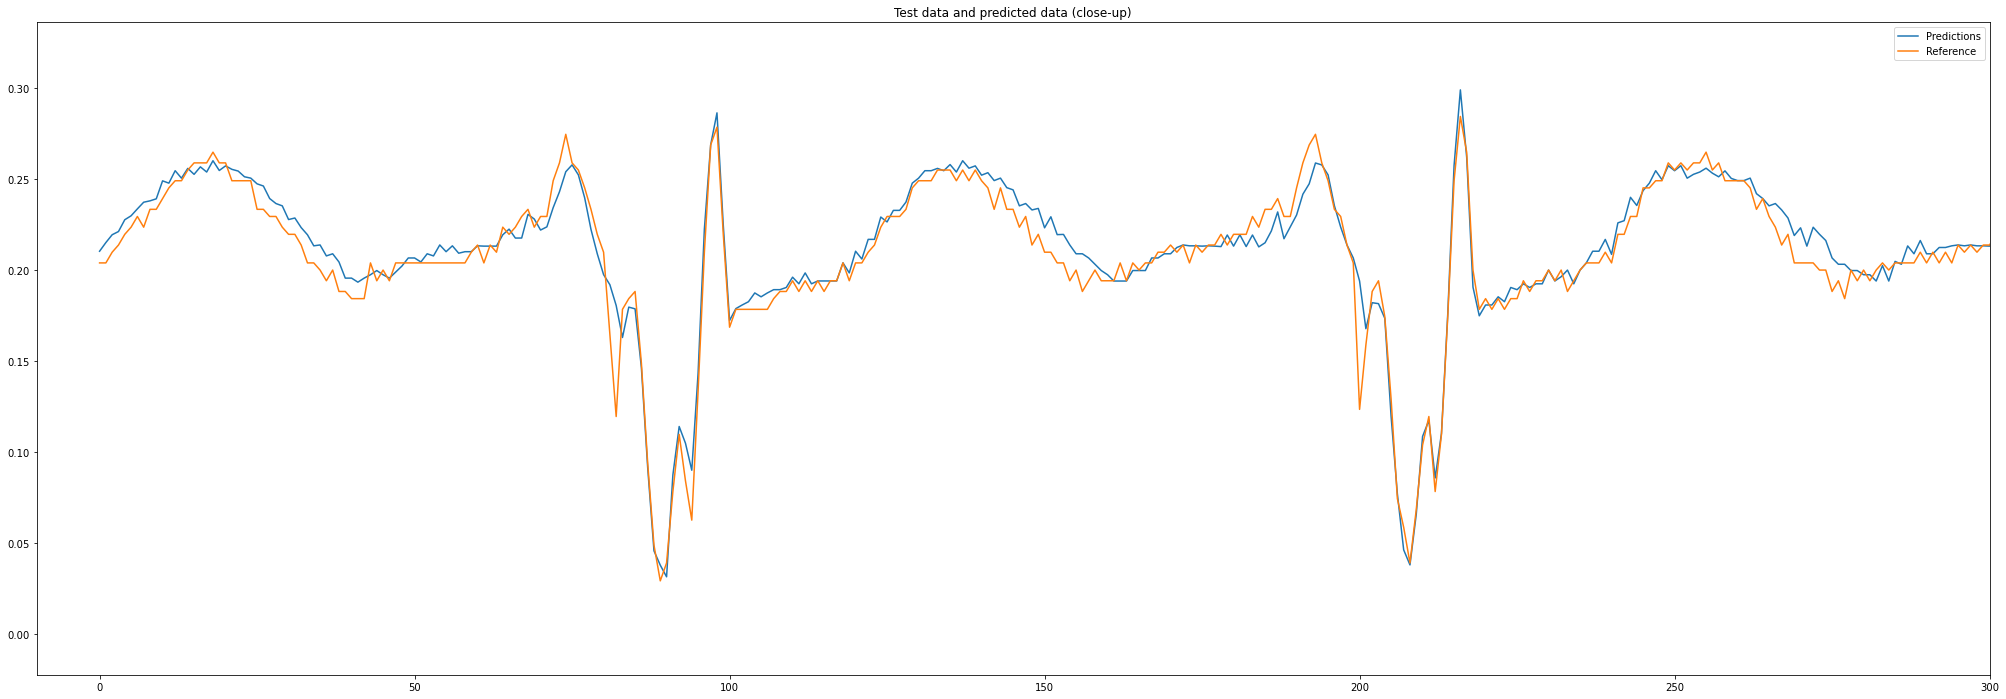

In [14]:
plt.figure(figsize=(35,12)) #(35,12)
#plt.ylim([-0.1, 0.4])
plt.xlim([-10, 300])
line_up, = plt.plot(test_predictions, label='Predictions')
line_down, = plt.plot(my_test_label, label='Reference')
plt.savefig('foo.png', bbox_inches='tight')
plt.legend(handles=[line_up, line_down])
plt.title('Test data and predicted data (close-up)')

In [15]:
mse = mean_squared_error(test_predictions,my_test_label)
print(mse)

0.00019707401723806462


In [16]:
a = test_predictions
np.savetxt("pat4final.csv", a, delimiter=",")